<a href="https://colab.research.google.com/github/krishan30/AiLERT-FYP/blob/main/DCL_Framework_with_huggingface_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install evaluate
!pip install accelerate -U
!pip install torchmetrics
!pip install optuna
!pip install -U "neptune[optuna]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.2/90.2 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.5/481.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler
from transformers import AutoModel,AutoTokenizer,AdamW,get_scheduler
from tqdm import tqdm
import evaluate
from datasets import load_dataset
from tqdm.auto import tqdm
import numpy as np
import random
import pandas as pd
from sklearn.utils import shuffle
from torchmetrics.classification import BinaryAccuracy,BinaryConfusionMatrix,BinaryF1Score,BinaryPrecision,BinaryRecall
from torchmetrics.collections import MetricCollection
from google.colab import userdata
import neptune
import neptune.integrations.optuna as npt_utils

In [39]:
from neptune.types import File

## Setting up the GPU or CPU

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["NEPTUNE_API_TOKEN"] = userdata.get('NEPTUNE_API_TOKEN')
os.environ["NEPTUNE_PROJECT"] = userdata.get('NEPTUNE_PROJECT')
device = torch.device("cuda:0"  if torch.cuda.is_available() else "cpu")

In [3]:
# @title Neptuna ID
study_id = "DCLFRAM-81" # @param {type:"string"}
trial_id = "DCLFRAM-107" # @param {type:"string"}

###Load the Study Run

In [43]:
run_study = neptune.init_run(with_id=study_id)

https://app.neptune.ai/FYP-DCL/DCL-Framework/e/DCLFRAM-81


### Load the Best Trail Run

In [5]:
run_trial = neptune.init_run(with_id=trial_id)

https://app.neptune.ai/FYP-DCL/DCL-Framework/e/DCLFRAM-107


In [6]:
best_prams=run_trial["parameters"].fetch()

## Hyperparameter Values

In [10]:
#@title #Variables
SEED = 1234 # @param {type:"integer"}
PADDING_MAX_LENGTH = 45 # @param {type:"integer"}

## Setting Random Seed for Reproducibility

In [11]:
def setup_seed(seed:int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    #torch.random.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


In [12]:
setup_seed(SEED)

In [14]:
# @title Bert Model
bert_model_name = "roberta-base" # @param {type:"string"}

## Loading Train,Dev,Test Datasets

In [15]:
data_files = {"test": "test.csv"}
dataset = load_dataset("krishan-CSE/HatEval_New", data_files=data_files)

In [16]:
dataset

DatasetDict({
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 3000
    })
})

## Loading the Tokernizer for the Transformer Model

In [17]:
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [18]:
def tokenize_function(examples):
    return tokenizer.batch_encode_plus(examples["text"], padding='max_length',max_length=PADDING_MAX_LENGTH,add_special_tokens=True,truncation=True)

## Tokenize the Dataset

In [19]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

## Remove Unwanted Coloumns

In [20]:
tokenized_datasets=tokenized_datasets.remove_columns(['text'])

## Format the coloumns

In [21]:
tokenized_datasets=tokenized_datasets.with_format("torch")

## Creating DataLoaders for Test Datasets

In [22]:
test_dataloader=DataLoader(tokenized_datasets["test"], batch_size=best_prams["BATCH_SIZE"] , shuffle=True)

## Define the Bert Architecture

In [23]:
class DCLArchitecture(nn.Module):
    def __init__(self,dropout:float,bert_model_name:str='bert-base-cased'):
        super(DCLArchitecture, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dim = 768
        self.dense = nn.Linear(self.dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self,batch_tokenized, if_train=False):
        input_ids = batch_tokenized['input_ids']
        attention_mask = batch_tokenized['attention_mask']
        bert_output = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        bert_cls_hidden_state = bert_output[1]
        torch.cuda.empty_cache()

        if if_train:
            bert_cls_hidden_state_aug = self.dropout(bert_cls_hidden_state)
            bert_cls_hidden_state = torch.cat((bert_cls_hidden_state, bert_cls_hidden_state_aug), dim=1).reshape(-1, self.dim)
        else:
            bert_cls_hidden_state = self.dropout(bert_cls_hidden_state)

        linear_output = self.dense(bert_cls_hidden_state)
        linear_output = linear_output.squeeze(1)

        return bert_cls_hidden_state, linear_output

## Define Focal Loss

In [24]:
class FocalLoss(nn.Module):
    def __init__(self, alpha:float=0.4, gamma:float=2, size_average:bool=True):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.size_average = size_average

    def forward(self, pred, target):

        device = target.device
        self.alpha = self.alpha.to(device)

        pred = nn.Sigmoid()(pred)
        pred = pred.view(-1, 1)
        target = target.view(-1, 1)
        pred = torch.cat((1-pred, pred), dim=1)

        class_mask = torch.zeros(pred.shape[0], pred.shape[1]).to(device)
        class_mask.scatter_(1, target.view(-1, 1).long(), 1.)
        probs = (pred * class_mask).sum(dim=1).view(-1, 1)
        probs = probs.clamp(min=0.0001, max=1.0)

        log_p = probs.log()
        alpha = torch.ones(pred.shape[0], pred.shape[1]).to(device)
        alpha[:, 0] = alpha[:, 0] * (1 - self.alpha)
        alpha[:, 1] = alpha[:, 1] * self.alpha
        alpha = (alpha * class_mask).sum(dim=1).view(-1, 1)

        batch_loss = -alpha * (torch.pow((1 - probs), self.gamma)) * log_p

        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()

        return loss

## Define Unsupervised Contrastive loss

In [25]:
def simcse_loss(batch_emb,temp_1:float):
    batch_size = batch_emb.size(0)
    y_true = torch.cat([torch.arange(1, batch_size, step=2, dtype=torch.long).unsqueeze(1),
                        torch.arange(0, batch_size, step=2, dtype=torch.long).unsqueeze(1)],
                       dim=1).reshape([batch_size,]).to(device)
    norm_emb = F.normalize(batch_emb, dim=1, p=2)
    sim_score = torch.matmul(norm_emb, norm_emb.transpose(0,1))
    sim_score = sim_score - (torch.eye(batch_size) * 1e12).to(device)
    sim_score = sim_score / temp_1
    loss_func = nn.CrossEntropyLoss()
    loss = loss_func(sim_score, y_true)

    return loss


## Define Supervised Contrastive loss

In [26]:
def sup_simcse_loss(batch_emb, label,temp_2:float):
    n = batch_emb.size(0)

    similarity_matrix = F.cosine_similarity(batch_emb.unsqueeze(1), batch_emb.unsqueeze(0), dim=2)
    mask = torch.ones_like(similarity_matrix) * (label.expand(n, n).eq(label.expand(n, n).t()))

    mask_no_sim = torch.ones_like(mask) - mask
    mask_dui_jiao_0 = ((torch.ones(n,n) - torch.eye(n,n)) * 1e12).to(device)
    similarity_matrix = torch.exp(similarity_matrix/temp_2)
    similarity_matrix = similarity_matrix * mask_dui_jiao_0

    sim = mask*similarity_matrix
    no_sim = similarity_matrix - sim
    no_sim_sum = torch.sum(no_sim , dim=1)
    no_sim_sum_expend = no_sim_sum.repeat(n, 1).T

    sim_sum  = sim + no_sim_sum_expend
    loss = torch.div(sim , sim_sum)
    loss = mask_no_sim + loss + (torch.eye(n, n)/1e12).to(device)
    loss = -torch.log(loss)
    loss = torch.sum(torch.sum(loss, dim=1))/(2*n)
    return loss

### Check with Test Dataset

In [27]:
def test_model(model, test_dataloader,criteon, device):
    collection_metric = MetricCollection(
          BinaryAccuracy(),
          BinaryPrecision(),
          BinaryRecall(),
          BinaryF1Score(),
    )
    collection_metric.to(device)
    bcm_metric = BinaryConfusionMatrix()
    bcm_metric.to(device)
    model.eval()

    total_test_loss = 0.0
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]
        with torch.no_grad():
            emb, pred = model(batch , False)
            loss = criteon(pred, labels.float())
        total_test_loss += loss.item()
        pred = torch.sigmoid(pred)
        collection_metric(pred,labels)
        bcm_metric(pred,labels)
    average_epoch_test_loss = total_test_loss / len(test_dataloader)  # Compute average epoch loss
    result =  collection_metric.compute()
    collection_metric.reset()
    return average_epoch_test_loss,result,bcm_metric

###Load the Model and Focal Loss

In [28]:
model = DCLArchitecture(bert_model_name=bert_model_name,dropout=best_prams["DROPOUT"])
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DCLArchitecture(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

In [29]:
criteon = FocalLoss(best_prams["ALPHA"],best_prams["GAMMA"])

### Load the Best Trail Checkpoint

In [30]:
def load_checkpoint(run: neptune.Run,check_point_name:str):
    model_ext = run[check_point_name]["model"].fetch_extension()
    criteon_ext = run[check_point_name]["criteon"].fetch_extension()
    run[check_point_name]["model"].download()  # Download the checkpoint
    run[check_point_name]["criteon"].download()
    run.wait()
    # Load the checkpoint
    checkpoint = {
        "model_state_dict":torch.load(f"model.{model_ext}"),
        "criteon_state_dict":torch.load(f"criteon.{criteon_ext}")
    }
    return checkpoint

In [31]:
check_point_name="model_checkpoints/"

In [32]:
checkpoint=load_checkpoint(run_trial,check_point_name)

In [33]:
criteon.load_state_dict(checkpoint["criteon_state_dict"])

<All keys matched successfully>

In [34]:
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

### Test the model with Test Set

In [35]:
average_epoch_test_loss,result_metrics,bcm_metric =test_model(model, test_dataloader,criteon, device)

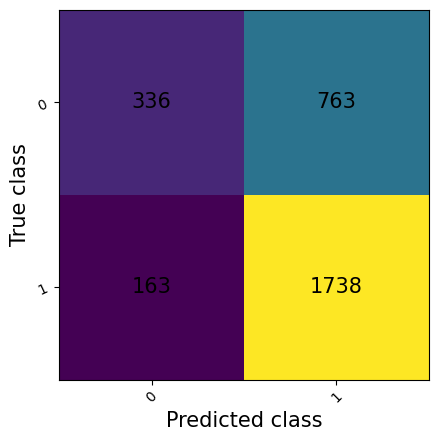

In [36]:
fig, ax = bcm_metric.plot()

In [37]:
result={
    "Accuracy":result_metrics["BinaryAccuracy"].item(),
    "Loss":average_epoch_test_loss,
    "Precision":result_metrics["BinaryPrecision"].item(),
    "Recall":result_metrics["BinaryRecall"].item(),
    "F1Score":result_metrics["BinaryF1Score"].item(),
    "confustion_matrix":fig
}

### Upload the Test Results to Neptuna

In [40]:
def upload_test_metrics(result,run: neptune.Run):
    run["Test_Result/Accuracy"]=result["Accuracy"]
    run["Test_Result/Loss"]=result["Loss"]
    run["Test_Result/Precision"]=result["Precision"]
    run["Test_Result/Recall"]=result["Recall"]
    run["Test_Result/F1Score"]=result["F1Score"]
    run["Test_Result/confustion_matrix"].upload(result["confustion_matrix"])
    run.wait()
    print("Upload Succesfull")


In [41]:
upload_test_metrics(result,run_study)

/usr/local/lib/python3.10/dist-packages/plotly/matplotlylib/renderer.py:523: UserWarning:

Aw. Snap! You're gonna have to hold off on the selfies for now. Plotly can't import images from matplotlib yet!



Upload Succesfull


In [42]:
run_trial.stop()
run_study.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/FYP-DCL/DCL-Framework/e/DCLFRAM-107/metadata
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/FYP-DCL/DCL-Framework/e/DCLFRAM-81/metadata
